In [50]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D

In [51]:
columns = ["COD_HOSPITAL"
,"CIP_ENCRIPTADO"
,"SEXO"
,"FECHA_NACIMIENTO"
,"PROVINCIA"
,"COMUNA"
,"NACIONALIDAD"
,"PREVISION"
,"SERVICIO_SALUD"
,"TIPO_PROCEDENCIA"
,"TIPO_INGRESO"
,"ESPECIALIDAD_MEDICA"
,"TIPO_ACTIVIDAD"
,"FECHA_INGRESO"
,"SERVICIOINGRESO"
,"FECHAALTA"
,"SERVICIOALTA"
,"TIPOALTA"
,"DIAGNOSTICO1"
,"DIAGNOSTICO2"
,"DIAGNOSTICO3"
,"DIAGNOSTICO4"
,"DIAGNOSTICO5"
,"DIAGNOSTICO6"
,"DIAGNOSTICO7"
,"DIAGNOSTICO8"
,"DIAGNOSTICO9"
,"DIAGNOSTICO10"
,"PROCEDIMIENTO1"
,"PROCEDIMIENTO2"
,"PROCEDIMIENTO3"
,"PROCEDIMIENTO4"
,"PROCEDIMIENTO5"
,"PROCEDIMIENTO6"
,"PROCEDIMIENTO7"
,"PROCEDIMIENTO8"
,"PROCEDIMIENTO9"
,"PROCEDIMIENTO10"
,"USOSPABELLON"
,"IR_29301_COD_GRD"
,"IR_29301_PESO"]

In [52]:
data = pd.read_csv(r'Datos\GRD_PUBLICO_2023.csv',sep='|',engine='python',encoding='utf-16', usecols=columns, na_values=["DESCONOCIDO"])

In [53]:
for col in ['FECHAALTA','FECHA_INGRESO','FECHA_NACIMIENTO']:
    data[col] = pd.to_datetime(data[col], errors='coerce')

C:\Users\benjo\AppData\Local\Temp\ipykernel_11416\3839240850.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [54]:
data.dropna(subset=['FECHA_INGRESO','FECHAALTA', 'FECHA_NACIMIENTO','PROVINCIA'], inplace=True, how='any')

In [55]:
date_cols = data[["FECHAALTA", "FECHA_INGRESO"]].copy()

for idx, row in date_cols.iterrows():
    if row['FECHAALTA'] < row['FECHA_INGRESO']:
        data.at[idx, 'FECHAALTA'], data.at[idx, 'FECHA_INGRESO'] = row['FECHA_INGRESO'], row['FECHAALTA']

In [56]:
data["DIAS_ESTANCIA"] = (data["FECHAALTA"] - data["FECHA_INGRESO"]).dt.days
data["EDAD"] = (data["FECHAALTA"] - data["FECHA_NACIMIENTO"]).dt.days // 365

In [57]:
data["IR_29301_PESO"] = data["IR_29301_PESO"].apply(lambda x: float(".".join(x.split(','))) if type(x) == str else x)

In [58]:
data

,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,PROVINCIA,COMUNA,NACIONALIDAD,PREVISION,SERVICIO_SALUD,TIPO_PROCEDENCIA,...,PROCEDIMIENTO6,PROCEDIMIENTO7,PROCEDIMIENTO8,PROCEDIMIENTO9,PROCEDIMIENTO10,USOSPABELLON,IR_29301_COD_GRD,IR_29301_PESO,DIAS_ESTANCIA,EDAD
0,122100,72196813.0,HOMBRE,1980-04-13,VALDIVIA,PANGUIPULLI,CHILE,FONASA INSTITUCIONAL - (MAI) A,VALDIVIA,SERVICIO EMERGENCIA (DOMICILIO),...,90.39,99.29,99.21,99.18,47.01,NaN,64161.0,0.7094,264,43
1,114101,NaN,HOMBRE,2001-11-04,CORDILLERA,PUENTE ALTO,VENEZUELA (REPÚBLICA BOLIVARIANA DE),PARTICULAR,METROPOLITANO SURORIENTE,SERVICIO EMERGENCIA (DOMICILIO),...,93.18,99.19,99.21,99.26,99.29,1.0,41301.0,1.0869,213,22
2,114101,97627974.0,HOMBRE,2020-07-30,CORDILLERA,PUENTE ALTO,CHILE,FONASA INSTITUCIONAL - (MAI) A,METROPOLITANO SURORIENTE,"APS URGENCIA (SAPU, SUR, SUC)",...,93.18,NaN,NaN,NaN,NaN,NaN,44161.0,0.4084,28,2
6,108100,77775513.0,MUJER,2012-11-08,SAN FELIPE,SANTA MARIA,CHILE,FONASA INSTITUCIONAL - (MAI) A,ACONCAGUA,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,NaN,NaN,1.0,31151.0,0.4106,177,10
7,112102,92070702.0,HOMBRE,2012-05-26,SANTIAGO,LO BARNECHEA,CHILE,FONASA INSTITUCIONAL - (MAI) C,METROPOLITANO ORIENTE,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,NaN,NaN,1.0,122150.0,0.3642,148,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039573,116105,100083528.0,MUJER,2023-10-05,TALCA,SAN CLEMENTE,CHILE,FONASA INSTITUCIONAL - (MAI) B,DEL MAULE,SERVICIO EMERGENCIA (DOMICILIO),...,89.04,NaN,NaN,NaN,NaN,NaN,158171.0,0.1055,62,0
1039576,116105,77921830.0,HOMBRE,2012-12-15,TALCA,TALCA,CHILE,FONASA INSTITUCIONAL - (MAI) A,DEL MAULE,SERVICIO EMERGENCIA (DOMICILIO),...,88.01,96.59,90.32,NaN,NaN,1.0,61131.0,0.7398,262,10
1039577,116105,92173518.0,HOMBRE,2013-08-09,DIGUILLÍN,CHILLAN,CHILE,FONASA INSTITUCIONAL - (MAI) C,ÑUBLE,SERVICIO EMERGENCIA (DOMICILIO),...,90.32,NaN,NaN,NaN,NaN,1.0,61131.0,0.7398,262,10
1039580,116105,75216538.0,HOMBRE,1949-07-30,TALCA,TALCA,CHILE,FONASA INSTITUCIONAL - (MAI) C,DEL MAULE,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,NaN,NaN,1.0,22360.0,0.4384,294,74


In [59]:
data.describe()

,COD_HOSPITAL,CIP_ENCRIPTADO,FECHA_NACIMIENTO,FECHA_INGRESO,FECHAALTA,PROCEDIMIENTO1,PROCEDIMIENTO2,PROCEDIMIENTO3,PROCEDIMIENTO4,PROCEDIMIENTO5,PROCEDIMIENTO6,PROCEDIMIENTO7,PROCEDIMIENTO8,PROCEDIMIENTO9,PROCEDIMIENTO10,USOSPABELLON,IR_29301_COD_GRD,IR_29301_PESO,DIAS_ESTANCIA,EDAD
count,406321.000000,4.057150e+05,406321,406321,406321,406244.000000,374255.000000,338982.000000,306867.000000,276357.000000,246396.000000,215953.000000,186269.000000,157719.000000,131619.000000,247861.000000,406312.000000,406312.000000,406321.000000,406321.000000
mean,113696.698854,7.840350e+07,1978-09-19 04:53:57.830188512,2023-04-27 09:46:26.139037440,2023-08-22 00:30:23.811223808,68.711870,76.411234,83.747138,86.734601,88.467635,89.187431,89.579161,89.521362,89.424086,89.223810,1.343576,90469.942296,0.963510,116.613862,44.464074
min,101100.000000,6.698809e+07,1918-01-21 00:00:00,2022-01-02 00:00:00,2023-01-01 00:00:00,0.090000,0.010000,0.010000,0.010000,0.010000,0.010000,0.090000,0.090000,0.090000,0.090000,0.000000,11011.000000,0.000000,0.000000,0.000000
25%,109100.000000,7.078918e+07,1956-09-01 00:00:00,2023-02-11 00:00:00,2023-07-01 00:00:00,51.230000,68.160000,87.440000,88.720000,89.130000,89.480000,89.520000,89.520000,89.520000,89.520000,1.000000,51113.000000,0.472600,49.000000,25.000000
50%,114101.000000,7.526309e+07,1978-10-12 00:00:00,2023-04-11 00:00:00,2023-09-06 00:00:00,75.340000,88.380000,90.420000,90.590000,91.320000,91.390000,91.390000,91.390000,91.360000,91.330000,1.000000,81072.500000,0.691500,107.000000,44.000000
75%,118100.000000,8.188552e+07,1998-01-18 00:00:00,2023-07-06 00:00:00,2023-11-06 00:00:00,88.720000,93.960000,99.190000,99.210000,99.210000,99.190000,99.190000,99.190000,99.180000,99.050000,1.000000,132130.000000,1.032800,176.000000,67.000000
max,133150.000000,1.008360e+08,2023-12-12 00:00:00,2023-12-12 00:00:00,2023-12-31 00:00:00,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,99.990000,8.000000,990129.000000,20.646100,665.000000,105.000000
std,6781.349981,1.005869e+07,NaN,NaN,NaN,26.714175,27.694728,23.778770,20.666995,18.024379,16.759293,16.021498,16.044708,15.915941,16.087705,0.777032,62580.760790,1.098241,82.762391,25.695063


In [60]:
data['Multimorbilidad'] = data[['DIAGNOSTICO1', 'DIAGNOSTICO2', 'DIAGNOSTICO3', 
                                'DIAGNOSTICO4', 'DIAGNOSTICO5', 'DIAGNOSTICO6', 
                                'DIAGNOSTICO7', 'DIAGNOSTICO8', 'DIAGNOSTICO9', 
                                'DIAGNOSTICO10']].notnull().sum(axis=1)

data['Multimorbilidad'] = (data['Multimorbilidad'] > 1).astype(int)


In [61]:
dataog = data.copy()

In [62]:
def no_outliers(data, column):
    print(column)
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [63]:
for column in ["DIAS_ESTANCIA", "IR_29301_PESO"]:
    data = no_outliers(data, column)
print((dataog.count() - data.count())/ dataog.count())


DIAS_ESTANCIA
IR_29301_PESO
COD_HOSPITAL           0.076609
CIP_ENCRIPTADO         0.076638
SEXO                   0.076606
FECHA_NACIMIENTO       0.076609
PROVINCIA              0.076609
COMUNA                 0.076609
NACIONALIDAD           0.076609
PREVISION              0.076609
SERVICIO_SALUD         0.076561
TIPO_PROCEDENCIA       0.076610
TIPO_INGRESO           0.076609
ESPECIALIDAD_MEDICA    0.076609
TIPO_ACTIVIDAD         0.076609
FECHA_INGRESO          0.076609
SERVICIOINGRESO        0.075623
FECHAALTA              0.076609
SERVICIOALTA           0.076109
TIPOALTA               0.076609
DIAGNOSTICO1           0.076609
DIAGNOSTICO2           0.087380
DIAGNOSTICO3           0.098949
DIAGNOSTICO4           0.113265
DIAGNOSTICO5           0.131362
DIAGNOSTICO6           0.151320
DIAGNOSTICO7           0.172658
DIAGNOSTICO8           0.196488
DIAGNOSTICO9           0.220385
DIAGNOSTICO10          0.244811
PROCEDIMIENTO1         0.076624
PROCEDIMIENTO2         0.082059
PROCEDIMIENT

<Axes: xlabel='IR_29301_PESO', ylabel='Count'>

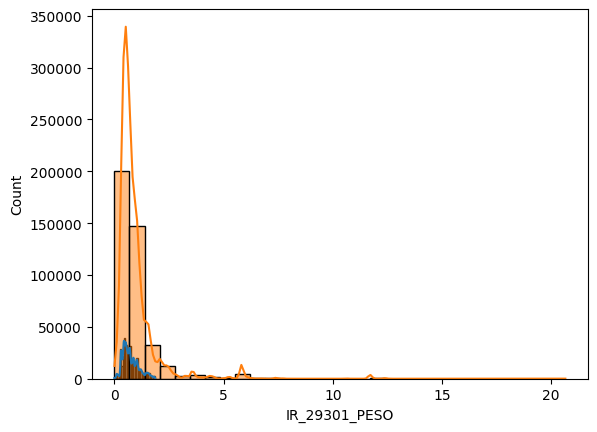

In [64]:
sns.histplot(data['IR_29301_PESO'], bins=30, kde=True)
sns.histplot(dataog['IR_29301_PESO'], bins=30, kde=True)

<Axes: xlabel='IR_29301_PESO', ylabel='Count'>

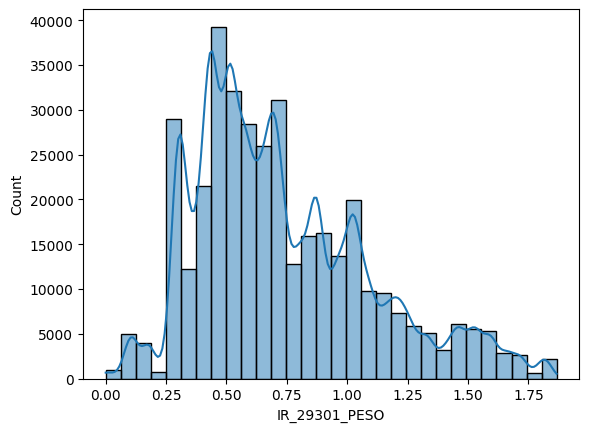

In [65]:
sns.histplot(data['IR_29301_PESO'], bins=30, kde=True)

- **Pregunta secundaria 1:** ¿Existe una relación significativa entre el costo y la edad de los pacientes?
- **Pregunta secundaria 2:** ¿Como distribuyen las personas con multimorbilidad en relación al costo?
- **Pregunta secundaria 3:** ¿Existen regiones cuyos costos sean diferentes en comparación al país?


In [66]:
bins = [0, 18, 40, 65, 200]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]


data["Rango_Etario"] = pd.cut(data["EDAD"], bins = bins, labels=labels, right=False)

<Axes: xlabel='Rango_Etario', ylabel='Count'>

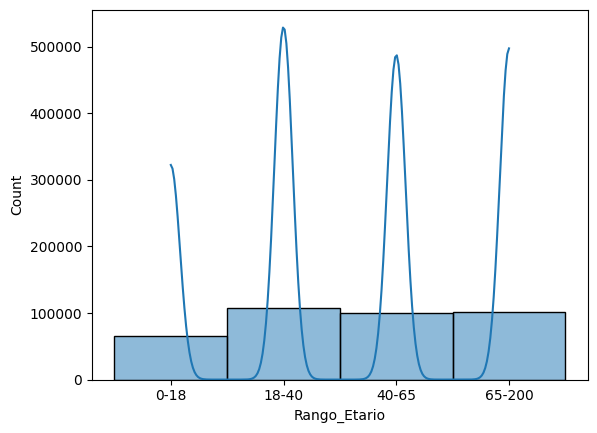

In [67]:
sns.histplot(data['Rango_Etario'], bins=30, kde=True)

In [68]:
#¿Existe una relación significativa entre el costo y la edad de los pacientes?
#H0: No existe relación significativa entre el costo y la edad de los pacientes
#H1: Existe relación significativa entre el costo y la edad de los pacientes
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
correlation, p_value = stats.pearsonr(data['IR_29301_PESO'], data['EDAD'])
print(f"Correlation: {correlation}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una relación significativa entre el costo y la edad de los pacientes")
else:
    print("No se rechaza la hipótesis nula, no existe una relación significativa entre el costo y la edad de los pacientes")


Correlation: 0.26136163655720096, P-value: 0.0
Rechazamos la hipótesis nula, existe una relación significativa entre el costo y la edad de los pacientes


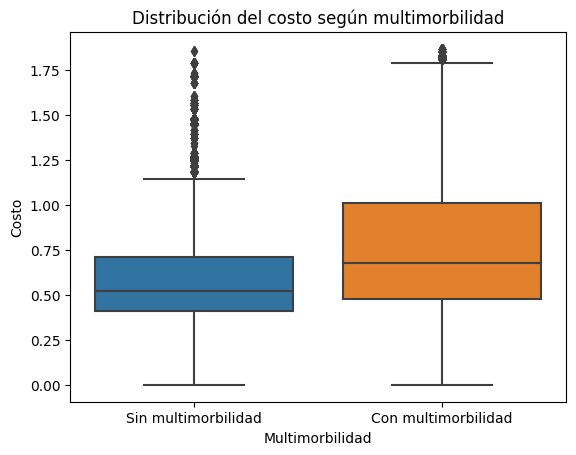

In [69]:
sns.boxplot(x='Multimorbilidad', y='IR_29301_PESO', data=data)
plt.xticks([0, 1], ['Sin multimorbilidad', 'Con multimorbilidad'])
plt.title('Distribución del costo según multimorbilidad')
plt.ylabel('Costo')
plt.xlabel('Multimorbilidad')
plt.show()

In [70]:
#¿Como distribuyen las personas con multimorbilidad en relación al costo?
#H0: No existe relación significativa entre el costo y la multimorbilidad
#H1: Existe relación significativa entre el costo y la multimorbilidad
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables

grupo_sin = data[data['Multimorbilidad'] == 0]['IR_29301_PESO']
grupo_con = data[data['Multimorbilidad'] == 1]['IR_29301_PESO']

t_stat, p_value = stats.ttest_ind(grupo_sin, grupo_con, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una diferencia significativa en el costo entre personas con y sin multimorbilidad.")
else:
    print("No se rechaza la hipótesis nula, no existe una diferencia significativa en el costo entre personas con y sin multimorbilidad.")


T-statistic: -135.22924819839915, P-value: 0.0
Rechazamos la hipótesis nula, existe una diferencia significativa en el costo entre personas con y sin multimorbilidad.


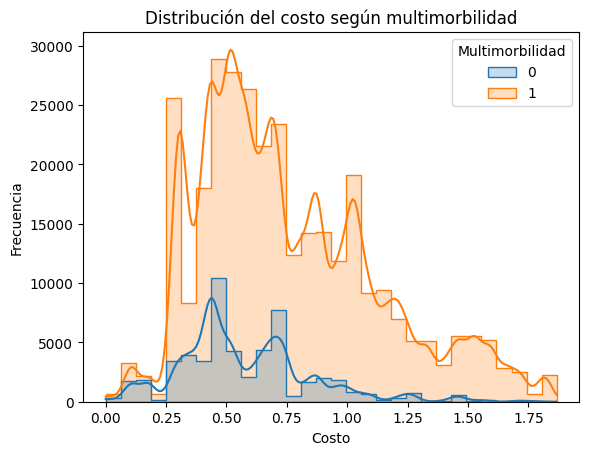

In [71]:
sns.histplot(data=data, x='IR_29301_PESO', hue='Multimorbilidad', kde=True, bins=30, element='step')
plt.title('Distribución del costo según multimorbilidad')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')
plt.show()


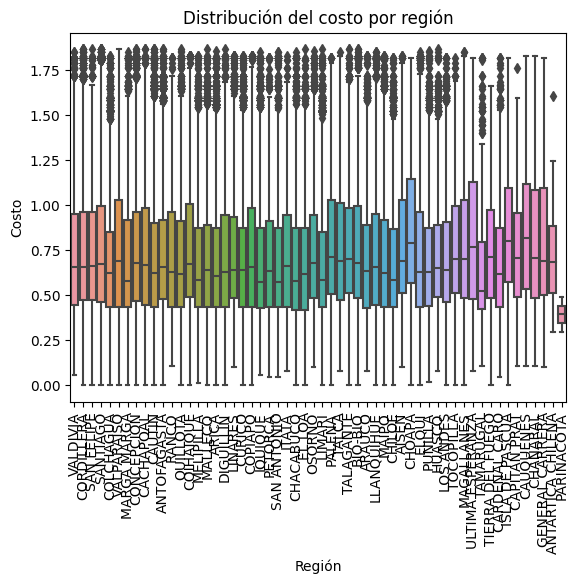

In [72]:
sns.boxplot(data=data, x='PROVINCIA', y='IR_29301_PESO')
plt.title('Distribución del costo por región')
plt.xticks(rotation=90)
plt.xlabel('Región')
plt.ylabel('Costo')
plt.show()

In [ ]:
grupos = [grupo['IR_29301_PESO'].dropna() for _, grupo in data.groupby('PROVINCIA')]

#ANOVA
f_stat, p_value = stats.f_oneway(*grupos)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos H0: Al menos una región tiene un costo significativamente diferente al promedio nacional.")
else:
    print("No se rechaza H0: No hay evidencia suficiente para afirmar diferencias entre regiones.")


F-statistic: 43.31261030501347, P-value: 0.0
Rechazamos H0: Al menos una región tiene un costo significativamente diferente al promedio nacional.


In [74]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=data['IR_29301_PESO'],
                          groups=data['PROVINCIA'],
                          alpha=0.05)
print(tukey)


           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
            AISEN       ANTOFAGASTA  -0.0534 0.1493 -0.1116  0.0048  False
            AISEN ANTÁRTICA CHILENA  -0.0293    1.0 -0.3426   0.284  False
            AISEN            ARAUCO  -0.0861    0.0 -0.1466 -0.0257   True
            AISEN             ARICA  -0.0899    0.0 -0.1479  -0.032   True
            AISEN           BIO-BIO  -0.0202    1.0 -0.0773  0.0369  False
            AISEN         CACHAPOAL  -0.0306 0.9981 -0.0881   0.027  False
            AISEN      CAPITAN PRAT  -0.0204    1.0 -0.1638   0.123  False
            AISEN     CARDENAL CARO  -0.0765 0.0234 -0.1493 -0.0036   True
            AISEN         CAUQUENES   0.0844 0.0327  0.0023  0.1665   True
            AISEN            CAUTIN  -0.0831    0.0 -0.1396 -0.0266   True
            AISEN        

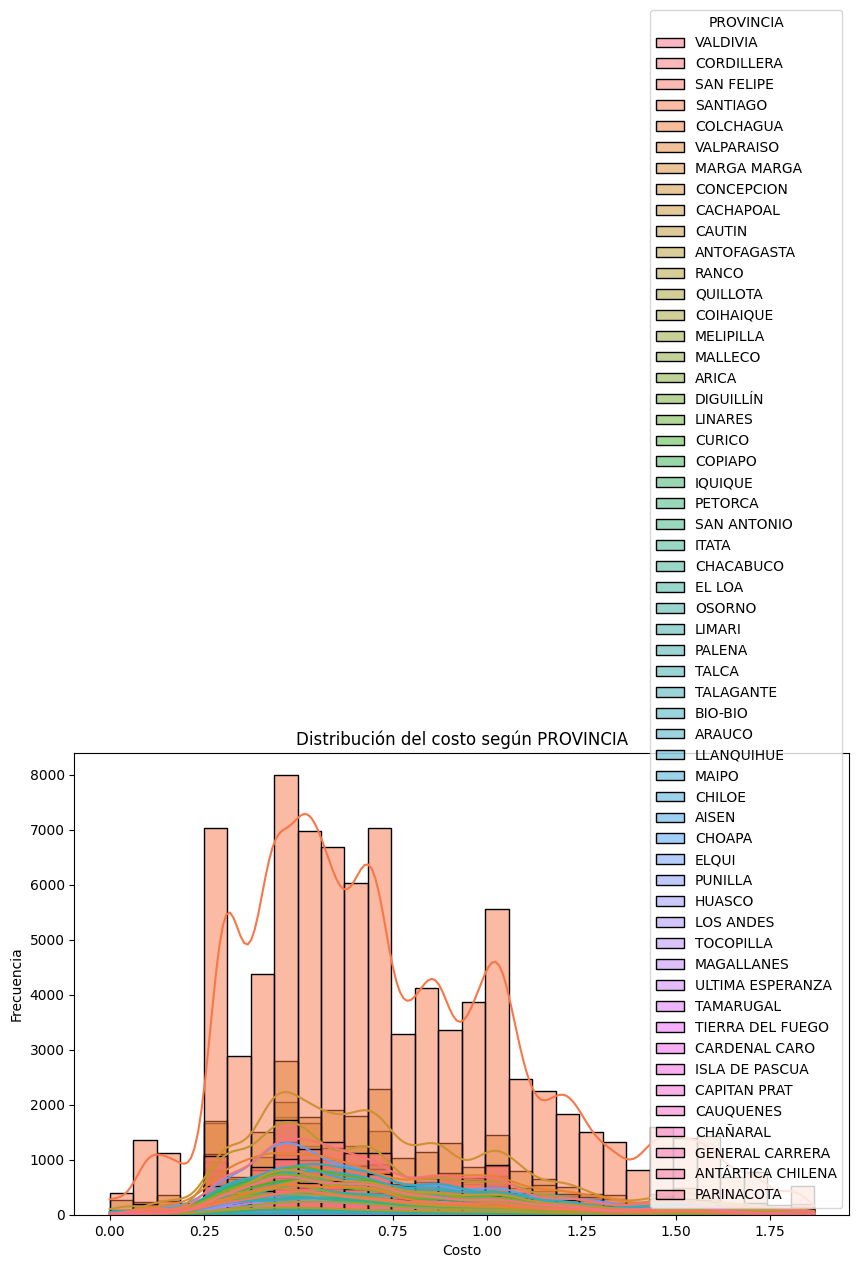

In [77]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='IR_29301_PESO', hue='PROVINCIA', kde=True, bins=30)
plt.title('Distribución del costo según PROVINCIA')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')
plt.show()

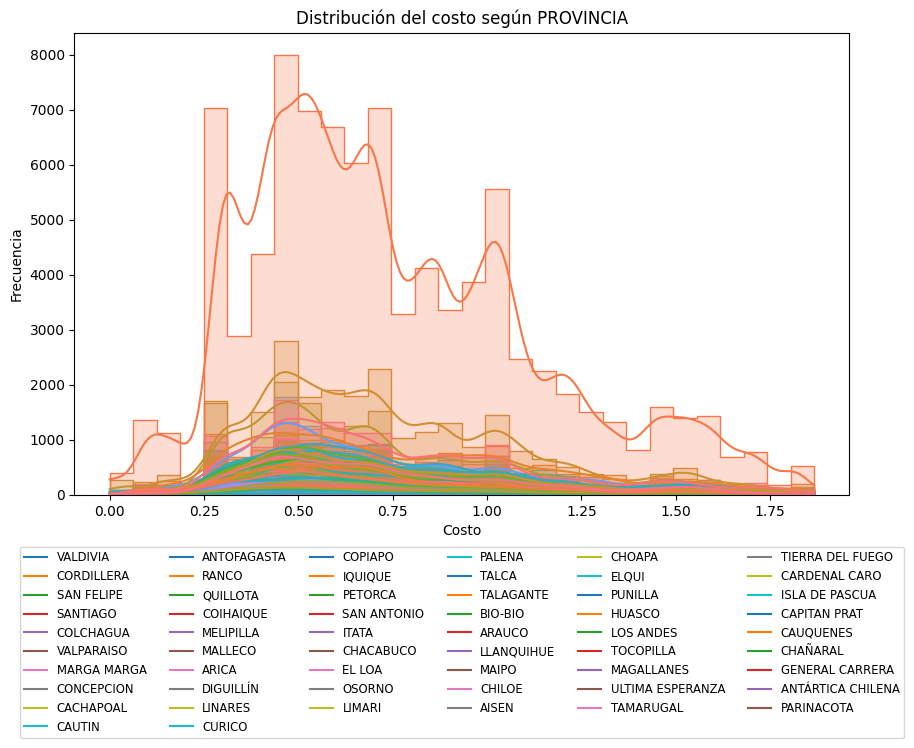

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='IR_29301_PESO', hue='PROVINCIA', kde=True, bins=30, element='step', legend=True)
plt.title('Distribución del costo según PROVINCIA')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')

unique_labels = list(data['PROVINCIA'].unique())
palette = sns.color_palette(n_colors=len(unique_labels))

handles = [Line2D([0], [0], color=palette[i]) for i in range(len(unique_labels))]

ax.legend(handles=handles, labels=unique_labels, ncol=6, fontsize='small', loc='upper center', bbox_to_anchor=(0.5, -0.1))

plt.show()